In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tensorflow import keras 
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [4]:
vectorizer_tf_idf = TfidfVectorizer(token_pattern = r"(?u)\b[a-zA-Z0-9_.]{2,}\b")
s = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\n',' '))
s = s.apply(lambda x : x.replace('$',''))
s = s.apply(lambda x : x.replace('/',''))
s = s.apply(lambda x : x.replace('<',''))
s = s.apply(lambda x : x.replace('>',''))
X_tf_idf = vectorizer_tf_idf.fit_transform(list(s)).toarray()
df_tf_idf = pd.DataFrame(data = X_tf_idf, columns = vectorizer_tf_idf.get_feature_names())
df_tf_idf.shape

(1000, 2244)

In [5]:
df_tf_idf = df_tf_idf * 5 

# 2. SimHash

In [6]:
%%time
embeddings = simhash(df_tf_idf)
embeddings

CPU times: user 2.59 s, sys: 4.84 ms, total: 2.6 s
Wall time: 2.62 s


array([[0., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 1.],
       [0., 0., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 0., 1.]])

# 3. Locality Sensitive Hashing

In [7]:
size_vector = 8
max_permutation = int(embeddings.shape[1] / size_vector)

l = list(np.arange(max_permutation))
combinations = list(itertools.combinations(l, 3))
hash_tables = create_hash_tables_simhash(combinations, embeddings, size_vector)

In [8]:
index = 397
set_near_duplicates = near_duplicates_simhash(index, combinations, embeddings, size_vector, hash_tables)
set_near_duplicates

{397, 469, 551}

In [9]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [10]:
near_duplicates_sim = df_measures['TfIdf'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

318068    0.850284
318150    0.850284
Name: TfIdf, dtype: float64

In [11]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'TfIdf', n_stacks, n_duplicate_pairs)
set_real_nns

{75, 469}

In [12]:
real_nns_sim[:n_duplicate_pairs]

72471     0.861783
318068    0.850284
dtype: float64

# 4. Metrics (SimHash)

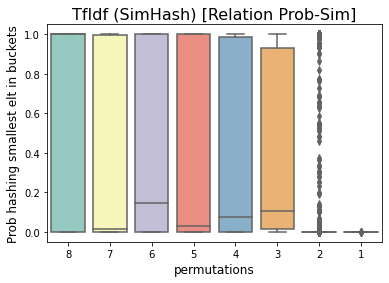

In [13]:
df_probLSH = mean_prob_hashing_smallest_elt_simhash(n_stacks, max_permutation, embeddings, size_vector, df_measures, 'TfIdf', trace = False)

f, ax = plt.subplots(figsize=(6, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.xlabel("permutations", fontsize = 12)
plt.ylabel("Prob hashing smallest elt in buckets", fontsize = 12)
plt.title('TfIdf (SimHash) [Relation Prob-Sim]', fontsize = 16)
plt.savefig('Results/SimHash/TfIdf-Relation-Prob-Sim', bbox_inches='tight')
plt.show()

## 4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [14]:
'All params'
k_first_positions = 1
recal_rate_simhash(n_stacks, max_permutation, embeddings, size_vector, df_measures, 'TfIdf', k_first_positions)

0.549

In [15]:
'Best param'
k_first_positions = 1
recal_rate_one_param_simhash (n_stacks, 3, embeddings, size_vector, df_measures, 'TfIdf', k_first_positions)

0.8169838945827232

-----------------------------------------------------------------

In [16]:
'All params'
k_first_positions = 3
recal_rate_simhash(n_stacks, max_permutation, embeddings, size_vector, df_measures, 'TfIdf', k_first_positions)

0.5459999999999999

In [17]:
'Best param'
k_first_positions = 3
recal_rate_one_param_simhash (n_stacks, 3, embeddings, size_vector, df_measures, 'TfIdf', k_first_positions)

0.7925925925925924

-----------------------------------------------------------------

In [18]:
'All params'
k_first_positions = 5
recal_rate_simhash(n_stacks, max_permutation, embeddings, size_vector, df_measures, 'TfIdf', k_first_positions)

0.552600000000001

In [19]:
'Best param'
k_first_positions = 5
recal_rate_one_param_simhash (n_stacks, 3, embeddings, size_vector, df_measures, 'TfIdf', k_first_positions)

0.8229166666666669

## 4.2. Generalized MRR

In [20]:
df_knns = mean_generalized_mrr_simhash (n_stacks, max_permutation, embeddings, size_vector, df_measures, 'TfIdf', trace = False)
df_knns.mean(skipna = True, axis = 0).mean()

0.7331818326538395

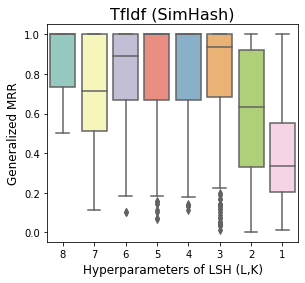

In [21]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_knns, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Generalized MRR", fontsize = 12)
plt.title('TfIdf (SimHash)', fontsize = 16)
plt.savefig('Results/SimHash/Generalized-MRR', bbox_inches='tight')
plt.show()

## 4.3. Recall w.r.t. LSH

In [22]:
df_recall = recall_all_simhash(n_stacks, max_permutation, embeddings, size_vector, df_measures , 'TfIdf', trace = False)
df_recall.mean(skipna = True, axis = 0)

8    0.168889
7    0.111833
6    0.167258
5    0.300146
4    0.430011
3    0.620497
2    0.745483
1    0.893676
dtype: float64

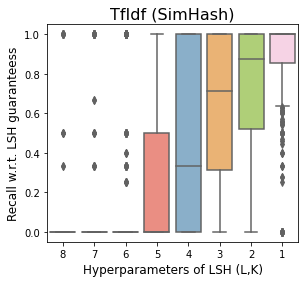

In [23]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_recall, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Recall w.r.t. LSH guaranteess", fontsize = 12)
plt.title('TfIdf (SimHash)', fontsize = 16)
plt.savefig('Results/SimHash/Recall-LSH', bbox_inches='tight')
plt.show()

## 4.4. Precision w.r.t. LSH

In [24]:
df_precision = precision_all_simhash(n_stacks, max_permutation, embeddings, size_vector, df_measures , 'TfIdf', trace = False)
df_precision.mean(skipna = True, axis = 0)

8    0.576923
7    0.328541
6    0.390394
5    0.426365
4    0.480289
3    0.493588
2    0.297293
1    0.062570
dtype: float64

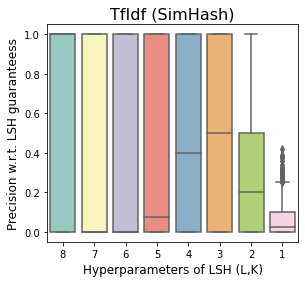

In [25]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_precision, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Precision w.r.t. LSH guaranteess", fontsize = 12)
plt.title('TfIdf (SimHash)', fontsize = 16)
plt.savefig('Results/SimHash/Precision-LSH', bbox_inches='tight')
plt.show()

## 4.5. Fscore w.r.t. LSH

In [29]:
df_score_all = fscore_all(df_precision, df_recall)
df_score_all.mean(skipna = True)

8    0.152941
7    0.087812
6    0.138015
5    0.223188
4    0.314407
3    0.411884
2    0.327742
1    0.105999
dtype: float64

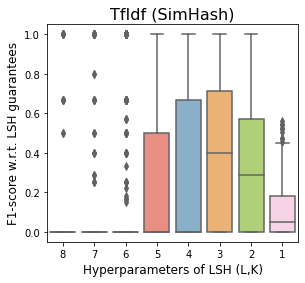

In [27]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_score_all, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("F1-score w.r.t. LSH guarantees", fontsize = 12)
plt.title('TfIdf (SimHash)', fontsize = 16)
plt.savefig('Results/SimHash/fscore-LSH', bbox_inches='tight')
plt.show()